# Import all libraries


In [22]:
import glob
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='once')

## Reading and preprocessing dataframe

In [23]:
def preprocessWeather(path_url):
    df = pd.read_csv(path_url)
    df.columns = df.columns.str.replace(' ', '')
    df[['FH', 'T', 'RH']] = df[['FH', 'T', 'RH']] / 10
    df['YYYYMMDD'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')
    df['date'] = df['YYYYMMDD'] +  pd.to_timedelta(df['HH'], unit='h')
    df.drop(columns = ['#STN', 'DD', 'FF', 'FX', 'T10N', 'TD', 'Q', 
                       'P', 'VV', 'U', 'WW', 'IX', 'HH', 'YYYYMMDD'], inplace=True)
    df.set_index('date', inplace=True)
    return df

def preprocessResono(path_url):
    df = pd.read_csv(path_url)
    df = df.drop(columns = ["Unnamed: 0"])
    return df

In [34]:
df_Weather2020 = preprocessWeather("KNMI (Weather) 2020-2021/uurgeg_240_2011-2020.txt")
df_Weather2021 = preprocessWeather("KNMI (Weather) 2020-2021/uurgeg_240_2021-2030_new.txt")

df_Resono = preprocessResono("resono_2020_2022.csv")

C:\Users\olivi\anaconda3\envs\my-r-env\lib\site-packages\ipykernel_launcher.py:1: DtypeWarning: Columns (15,16,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


#### Preprocessing of the weather data

In [41]:
df_weather = pd.concat([df_Weather2020, df_Weather2021], axis=0)
df_weather = df_weather.loc['2020-10':]

cols_int = ['SQ', 'DR', 'N', 'M', 'R', 'S', 'O', 'Y']
cols_float = ['FH', 'T']

df_weather[cols_float] = df_weather[cols_float].apply(pd.to_numeric, errors='coerce', axis=1)
df_weather[cols_int] = df_weather[cols_int].apply(pd.to_numeric, errors='coerce', axis=1)
df_weather['RH'] = df_weather['RH'].apply(lambda x: 0.05 if x==-0.1 else x)


In [42]:
df_weather_resample = pd.concat([df_weather[['FH', 'T', 'N']].resample('15T').interpolate(method='linear'),
                    df_weather[['RH', 'DR', 'SQ', 'M', 'R', 'S', 'O', 'Y']].resample('15T').bfill()],
                   axis=1)

df_weather_resample[['DR', 'SQ']] = df_weather_resample[['DR', 'SQ']] * 1.5
df_weather_resample['RH'] = df_weather_resample['RH'] / 4

#### Merging the Resono and weather data and rename columns

In [43]:
#df_Resono = df_Resono_Oct_Dec.drop(columns = ["Unnamed: 0"])
df_Resono['End'] = pd.to_datetime(df_Resono['End'])
df_Resono['End'] = pd.to_datetime(df_Resono['End'].dt.strftime("%Y-%m-%d %H:%M:%S"))

In [44]:
df_Resono_index = df_Resono.set_index('End')
df_Resono_index = df_Resono_index.loc['2020-10':]

C:\Users\olivi\anaconda3\envs\my-r-env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  


In [49]:
merge_resono_weather = pd.merge(df_Resono_index, df_weather_resample, left_index=True, right_index=True, how='left')
merge_resono_weather = merge_resono_weather.rename({'T': 'Temperature', 'N': 'Clouds', 'FH': 'Windspeed',
                                                    'RH': 'Rain amount', 'DR': 'Rain duration' , 'SQ': 'Sun duration',
                                                    'M': 'Fog', 'R': 'Rain', 'S': 'Snow', 'O': 'Thunder', 'Y': 'Ice'},
                                                   axis=1) 
merge_resono_weather

,Location,Visits,End_Dates,End_Time,Windspeed,Temperature,Clouds,Rain amount,Rain duration,Sun duration,Fog,Rain,Snow,Thunder,Ice
2020-10-01 00:15:00,Erasmuspark,243,2020-10-01,00:15:00,5.0,15.575,8.00,0.0,0.0,0.0,0,0,0,0,0
2020-10-01 00:15:00,Oosterpark,53,2020-10-01,00:15:00,5.0,15.575,8.00,0.0,0.0,0.0,0,0,0,0,0
2020-10-01 00:15:00,Rembrandtpark Noord,123,2020-10-01,00:15:00,5.0,15.575,8.00,0.0,0.0,0.0,0,0,0,0,0
2020-10-01 00:15:00,Rembrandtpark Zuid,138,2020-10-01,00:15:00,5.0,15.575,8.00,0.0,0.0,0.0,0,0,0,0,0
2020-10-01 00:15:00,Sarphatipark,96,2020-10-01,00:15:00,5.0,15.575,8.00,0.0,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06 14:45:00,Sarphatipark,654,2022-01-06,14:45:00,5.0,5.400,3.25,0.0,0.0,15.0,0,0,0,0,0
2022-01-06 14:45:00,Vondelpark West,332,2022-01-06,14:45:00,5.0,5.400,3.25,0.0,0.0,15.0,0,0,0,0,0
2022-01-06 14:45:00,Westergasfabriek,68,2022-01-06,14:45:00,5.0,5.400,3.25,0.0,0.0,15.0,0,0,0,0,0
2022-01-06 15:00:00,Sarphatipark,776,2022-01-06,15:00:00,5.0,5.200,4.00,0.0,0.0,15.0,0,0,0,0,0


<AxesSubplot:xlabel='Temperature', ylabel='Visits'>

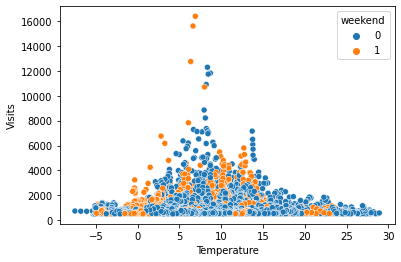

In [79]:
oosterpark = merge_resono_weather[merge_resono_weather.Location == 'Sarphatipark']
oosterpark = oosterpark[oosterpark.Visits > 500]
oosterpark = oosterpark.between_time('08:00', '22:00')
oosterpark.reset_index(inplace=True)
oosterpark['weekend'] = oosterpark['index'].apply(lambda x: 1 if (x.weekday() == 5) or (x.weekday() == 6) else 0)

sns.scatterplot(data=oosterpark, x="Temperature", y="Visits", hue='weekend')

In [51]:
'''
Windspeed       = Mean wind speed during the time period (in m/s)
Temperature     = Temperature at 1.50 m at the time of observation
Clouds          = Cloud cover (in octants), at the time of observation (9=sky invisible)
Rain amount     = Quarterly precipitation amount
Rain duration   = Precipitation duration during the quarterly division (in minutes)
Sun duration    = Sunshine duration (in minutes)
Fog             = Fog  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
Rain            = Rain  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
Snow            = Snow  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
Thunder         = Thunder  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
Ice             = Ice  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
'''

In [81]:
df_Resono.groupby('Location').count()

,End,Visits,End_Dates,End_Time
Location,,,,
Erasmuspark,42128,42128,42128,42128
Oosterpark,42128,42128,42128,42128
Rembrandtpark Noord,4159,4159,4159,4159
Rembrandtpark Zuid,4159,4159,4159,4159
Sarphatipark,42129,42129,42129,42129
Vondelpark Oost,18092,18092,18092,18092
Vondelpark West,42129,42129,42129,42129
Westergasfabriek,36834,36834,36834,36834


In [73]:
oosterpark

,level_0,index,Location,Visits,End_Dates,End_Time,Windspeed,Temperature,Clouds,Rain amount,Rain duration,Sun duration,Fog,Rain,Snow,Thunder,Ice,weekend
0,0,2020-10-01 08:00:00,Oosterpark,665,2020-10-01,08:00:00,5.00,14.500,8.0,0.050,9.0,0.0,0,1,0,0,0,0
1,1,2020-10-01 08:15:00,Oosterpark,636,2020-10-01,08:15:00,5.25,14.525,8.0,0.125,15.0,0.0,0,1,0,0,0,0
2,2,2020-10-01 08:30:00,Oosterpark,736,2020-10-01,08:30:00,5.50,14.550,8.0,0.125,15.0,0.0,0,1,0,0,0,0
3,3,2020-10-01 08:45:00,Oosterpark,534,2020-10-01,08:45:00,5.75,14.575,8.0,0.125,15.0,0.0,0,1,0,0,0,0
4,4,2020-10-01 09:00:00,Oosterpark,563,2020-10-01,09:00:00,6.00,14.600,8.0,0.125,15.0,0.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10823,10823,2022-01-04 14:45:00,Oosterpark,507,2022-01-04,14:45:00,3.25,5.975,8.0,0.000,0.0,4.5,0,0,0,0,0,0
10824,10824,2022-01-04 15:00:00,Oosterpark,575,2022-01-04,15:00:00,3.00,6.000,8.0,0.000,0.0,4.5,0,0,0,0,0,0
10825,10825,2022-01-05 08:30:00,Oosterpark,543,2022-01-05,08:30:00,11.50,5.850,8.0,0.150,7.5,0.0,0,1,0,0,0,0
10826,10826,2022-01-05 08:45:00,Oosterpark,507,2022-01-05,08:45:00,11.75,5.975,8.0,0.150,7.5,0.0,0,1,0,0,0,0
